Based on **Graph Based Approaches for Image Segmentation and Object Tracking**, Xiaofang Wang, September 2014.



Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx

## Directed Acyclic Graph Construction

+ $D = (V,A)$,

+ $V = F_1 \cup F_2 \ldots F_n$, where $n$ is a number of frames,

+ $(u,v) \in A \iff u \in F_l,\ v \in F_{l+1}$ for some $l \in \{1, \ldots, n-1\}$ and $dist(u,v) \leq d_{max}$ (we consider Euclidean distance since $u = (x_1, y_1)$ and $v = (x_2, y_2)$ - coordinates of segments' centroids).

Possible situations:
1. $v \in F_k$ has no neighbor in $F_{k+1}$,
2. $v \in F_k$ has exactly one neighbor in $F_{k+1}$,
3. $v \in F_k$ has more than one neighbor in $F_{k+1}$,
4. $v, u \in F_k,\ v \neq u$ has the same neighbor $w \in F_{k+1}$,

In [ ]:
# TODO
# miejsce na schemat - rysunek z kolejnymi frame'ami, segmentami i połączeniami między nimi

Hyperparameters

In [ ]:
# d_max = ? # dist max -> dlugosc przekatnej frame'a?
# number_of_frames = ?

Utils

In [2]:
def get_arc_weight(vertex1, vertex2, d_max):
    # vertex = (x,y,z), where x,y - coords, z - frame number
    dist = np.linalg.norm(np.array(vertex1[:2]) - np.array(vertex2[:2]))
    return dist / d_max

## Graph refinement

Methods:
1. **Configuration I (PI)** - case of missing connection - this can be easily fixed by simply increasing the search range until a neighborhood is found.


2. **Configuration II (PII)** - case where one node connects to two neighbors which are far from each other.  Link with the most distant node is removed from the graph. Let us emphasize that in case a node has more than three neighbors, only the most distant onis removed.


3. **Configuration III (PIII)** - another conflicting situation where two nodes are connected to the same neighbor in $F_{k+1}$. If only one of the node has more than two neighbors then its connection with the common neighbor is removed. If both nodes have more than two neighbors, the longest connection with the common neighbor is removed.

Notice that after these procedures we get a graph that still can have redundant connections. It is shown that repeating above steps of reduction does not improve the result significantly.

## Full Trajectories via Min-cost/max Flow

We expand directed graph $D$ in the following manner:
+ $V := V \cup \{s, t\}$,
+ every arc $(u,v)$ has unit capacity $c$,
+ $f_{uv}$ is a volume of flow from $u$ to $v$ along $e_{uv}$, $f_{uv} \in [0,1]$ or $f_{uv} \in [-1,0]$ (when $(u,v)$ is negatively oriented), in general $f_{uv} = - f_{vu}$,
+ $w_{uv}$ is a cost per unit flow on $e_{uv}$, namely: $w_{uv} = dist(u,v) / d_{max}$,
+ edges from $s$ or to $t$ have no cost,
+ sum of inflow and outflow volumes are equal at each node except $s$ and $t$.

Sending a volume $m$ of a circulation flow from $s$ to $t$, and looking for the flow
repartition along the graph with minimal cost is equivalent to solving the following
problem [Ahuja et al., 1993]:

<center>argmin$_f \sum_{(u,v) \in A} w_{uv} f_{uv}$</center>

Initial graph refinement algorithm

In [3]:
def get_num_frames(graph):
    num_frames = -1
    for vertex in graph:
        if vertex[2] > num_frames:
            num_frames = vertex[2]
    return num_frames + 1 # frames indexing starts from 0

In [4]:
def vertices_from_ith_frame(graph, i):
    vertices = []
    for vertex in graph:
        if vertex[2] == i:
            vertices.append(vertex)
    return vertices

In [5]:
def get_distance(vertex1, vertex2):
    return np.linalg.norm(np.array(vertex1[:2]) - np.array(vertex2[:2]))

In [6]:
def get_neighbors(vertex, vertices, d_max):
    neighbors = []
    for vertex2 in vertices:
        if get_distance(vertex, vertex2) <= d_max:
            neighbors.append(vertex2)
    return neighbors

In [7]:
def get_most_distant_neighbor(vertex, neighbors):
    d_max = 0
    most_distant_neighbor = neighbors[0]
    for neighbor in neighbors:
        if d_max < get_distance(vertex, neighbor):
            d_max = get_distance(vertex, neighbor)
            most_distant_neighbor = neighbor
    return most_distant_neighbor

In [8]:
def get_common_neighbors(vertex1, vertex2, vertices_from_next_frame, d_max):
    neighbors1 = get_neighbors(vertex1, vertices_from_next_frame, d_max)
    neighbors2 = get_neighbors(vertex2, vertices_from_next_frame, d_max)
    return list(set(neighbors1).intersection(set(neighbors2)))

In [9]:
def initial_graph_refinement(graph, dist_max, dist_border):
    # graph.nodes consists of vertices as follows: (x,y,z), where x,y - are Cartesian coordinates,
    # z -  frame's number
    
    num_frames = get_num_frames(graph)
    
    for i in range(num_frames - 1):
        for vertex in vertices_from_ith_frame(graph, i):
            neighbors = get_neighbors(vertex, vertices_from_ith_frame(graph, i + 1), dist_max)
            # configuration I
            if len(neighbors) == 0:
                dist = dist_max
                while len(neighbors) == 0 and dist < dist_border:
                    dist = dist * 1.5
                    neighbors = get_neighbors(vertex, vertices_from_ith_frame(graph, i + 1), dist_max)
                if len(neighbors) > 0:
                    graph.add_edge(vertex, neighbors[0])    
            
            # configuration II
            if len(neighbors) > 1:
                # simplified... just for now
                neighbor = get_most_distant_neighbor(vertex, neighbors)
                graph.remove_edge(vertex, neighbor)
            
            # configuration III
            for vertex2 in vertices_from_ith_frame(graph, i):
                neighbors = get_common_neighbors(vertex, vertex2, vertices_from_ith_frame(graph, i + 1), dist_max)
                if vertex != vertex2 and len(neighbors) > 0:
                    if len(get_neighbors(vertex, vertices_from_ith_frame(graph, i + 1), dist_max)) > 2 and len(get_neighbors(vertex2, vertices_from_ith_frame(graph, i + 1, dist_max))) <= 2: 
                        print("Removing", vertex, "-", neighbors[0])
                        graph.remove_edge(vertex, neighbors[0])
                    elif len(get_neighbors(vertex2, vertices_from_ith_frame(graph, i + 1), dist_max)) > 2 and len(get_neighbors(vertex, vertices_from_ith_frame(graph, i + 1, dist_max))) <= 2: 
                        print("Removing", vertex2, "-", neighbors[0])
                        graph.remove_edge(vertex2, neighbors[0])
                    else:
                        dist1 = get_distance(vertex, neighbors[0])
                        dist2 = get_distance(vertex2, neighbors[0])
                        if dist1 > dist2: # trzeba przemyslec usuwanie...
                            if (vertex, neighbors[0]) in graph.edges: ### uwaga - rozwazam po 2 razy te same pary..
                                print("Removing", vertex, "-", neighbors[0])
                                graph.remove_edge(vertex, neighbors[0])
                        else:
                            if (vertex2, neighbors[0]) in graph.edges: ### uwaga - rozwazam po 2 razy te same pary..
                                print("Removing", vertex2, "-", neighbors[0])
                                graph.remove_edge(vertex2, neighbors[0])
                            
        

Example

In [10]:
trace1 = [2 * x + 4 for x in range(10)]
trace2 = [math.exp(0.1 * x) for x in range(10)]
trace3 = [math.sin(x) - 3 for x in range(10)]

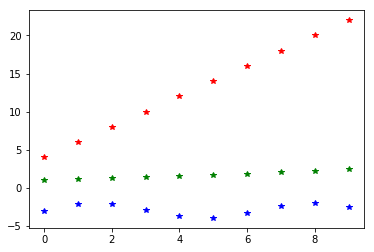

In [11]:
plt.plot(range(10), trace1, 'r*')
plt.plot(range(10), trace2, 'g*')
plt.plot(range(10), trace3, 'b*')

As we can see above there are 3 objects to track with 10 frames $([F_0,F_1,...,F_9])$.

In [12]:
num_frames = 10

In [13]:
frames = []
for i in range(num_frames):
    frames.append([trace1[i], trace2[i], trace3[i]])

Initial graph creation.

In [14]:
G = nx.DiGraph()

In [15]:
# adding nodes
for i in range(num_frames):
    frame_number = i
    G.add_node((i, trace1[i], frame_number), pos=(i, trace1[i]))
    G.add_node((i, trace2[i], frame_number), pos=(i, trace2[i]))
    G.add_node((i, trace3[i], frame_number), pos=(i, trace3[i]))

In [16]:
# adding edges (arcs)
d_max = 3
for frame_number in range(num_frames - 1): # we set attributes for FF
    for vertex1 in vertices_from_ith_frame(G, frame_number):
        for vertex2 in vertices_from_ith_frame(G, frame_number + 1):
            if get_distance(vertex1, vertex2) < d_max:
                weight = int(10 * get_distance(vertex1, vertex2) / d_max) #####
                G.add_edge(vertex1, vertex2, capacity=10, weight=weight)

In [17]:
get_num_frames(G)

10

In [18]:
dist_border = 30 # should be a distnace between two the most distant vertices

In [19]:
# before
print(G.edges)

[((0, 4, 0), (1, 6, 1)), ((0, 1.0, 0), (1, 1.1051709180756477, 1)), ((0, -3.0, 0), (1, -2.1585290151921033, 1)), ((1, 6, 1), (2, 8, 2)), ((1, 1.1051709180756477, 1), (2, 1.2214027581601699, 2)), ((1, -2.1585290151921033, 1), (2, -2.090702573174318, 2)), ((2, 8, 2), (3, 10, 3)), ((2, 1.2214027581601699, 2), (3, 1.3498588075760032, 3)), ((2, -2.090702573174318, 2), (3, -2.8588799919401326, 3)), ((3, 10, 3), (4, 12, 4)), ((3, 1.3498588075760032, 3), (4, 1.4918246976412703, 4)), ((3, -2.8588799919401326, 3), (4, -3.7568024953079284, 4)), ((4, 12, 4), (5, 14, 5)), ((4, 1.4918246976412703, 4), (5, 1.6487212707001282, 5)), ((4, -3.7568024953079284, 4), (5, -3.9589242746631386, 5)), ((5, 14, 5), (6, 16, 6)), ((5, 1.6487212707001282, 5), (6, 1.822118800390509, 6)), ((5, -3.9589242746631386, 5), (6, -3.279415498198926, 6)), ((6, 16, 6), (7, 18, 7)), ((6, 1.822118800390509, 6), (7, 2.0137527074704766, 7)), ((6, -3.279415498198926, 6), (7, -2.343013401281211, 7)), ((7, 18, 7), (8, 20, 8)), ((7, 2.

In [20]:
initial_graph_refinement(G, d_max, dist_border)

In [21]:
# after
print(G.edges)

[((0, 4, 0), (1, 6, 1)), ((0, 1.0, 0), (1, 1.1051709180756477, 1)), ((0, -3.0, 0), (1, -2.1585290151921033, 1)), ((1, 6, 1), (2, 8, 2)), ((1, 1.1051709180756477, 1), (2, 1.2214027581601699, 2)), ((1, -2.1585290151921033, 1), (2, -2.090702573174318, 2)), ((2, 8, 2), (3, 10, 3)), ((2, 1.2214027581601699, 2), (3, 1.3498588075760032, 3)), ((2, -2.090702573174318, 2), (3, -2.8588799919401326, 3)), ((3, 10, 3), (4, 12, 4)), ((3, 1.3498588075760032, 3), (4, 1.4918246976412703, 4)), ((3, -2.8588799919401326, 3), (4, -3.7568024953079284, 4)), ((4, 12, 4), (5, 14, 5)), ((4, 1.4918246976412703, 4), (5, 1.6487212707001282, 5)), ((4, -3.7568024953079284, 4), (5, -3.9589242746631386, 5)), ((5, 14, 5), (6, 16, 6)), ((5, 1.6487212707001282, 5), (6, 1.822118800390509, 6)), ((5, -3.9589242746631386, 5), (6, -3.279415498198926, 6)), ((6, 16, 6), (7, 18, 7)), ((6, 1.822118800390509, 6), (7, 2.0137527074704766, 7)), ((6, -3.279415498198926, 6), (7, -2.343013401281211, 7)), ((7, 18, 7), (8, 20, 8)), ((7, 2.

In [22]:
# This digraph can be now extended for FF algorithm

In [23]:
# new nodes
source = (-1,-1,-1)
G.add_node(source, pos=(-1,1)) # source
sink = (-2,-2,-2)
G.add_node(sink, pos=(10,1)) # sink

In [24]:
# new edges
for vertex in vertices_from_ith_frame(G, 0):
    G.add_edge(source, vertex, capacity=10, weight=0)

for vertex in vertices_from_ith_frame(G, get_num_frames(G) - 1):
    G.add_edge(vertex, sink, capacity=10, weight=0)

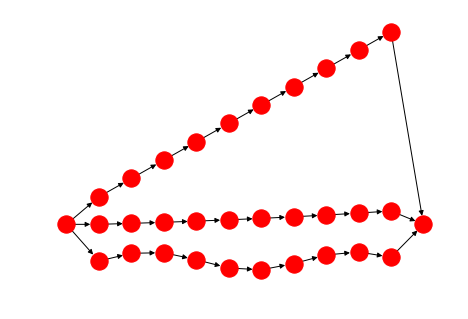

In [25]:
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos)

In [26]:
for edge in G.edges:
    print(edge, G.get_edge_data(*edge))

((0, 4, 0), (1, 6, 1)) {'capacity': 10, 'weight': 7}
((0, 1.0, 0), (1, 1.1051709180756477, 1)) {'capacity': 10, 'weight': 3}
((0, -3.0, 0), (1, -2.1585290151921033, 1)) {'capacity': 10, 'weight': 4}
((1, 6, 1), (2, 8, 2)) {'capacity': 10, 'weight': 7}
((1, 1.1051709180756477, 1), (2, 1.2214027581601699, 2)) {'capacity': 10, 'weight': 3}
((1, -2.1585290151921033, 1), (2, -2.090702573174318, 2)) {'capacity': 10, 'weight': 3}
((2, 8, 2), (3, 10, 3)) {'capacity': 10, 'weight': 7}
((2, 1.2214027581601699, 2), (3, 1.3498588075760032, 3)) {'capacity': 10, 'weight': 3}
((2, -2.090702573174318, 2), (3, -2.8588799919401326, 3)) {'capacity': 10, 'weight': 4}
((3, 10, 3), (4, 12, 4)) {'capacity': 10, 'weight': 7}
((3, 1.3498588075760032, 3), (4, 1.4918246976412703, 4)) {'capacity': 10, 'weight': 3}
((3, -2.8588799919401326, 3), (4, -3.7568024953079284, 4)) {'capacity': 10, 'weight': 4}
((4, 12, 4), (5, 14, 5)) {'capacity': 10, 'weight': 7}
((4, 1.4918246976412703, 4), (5, 1.6487212707001282, 5)) {

In [27]:
source

(-1, -1, -1)

In [28]:
sink

(-2, -2, -2)

In [29]:
# uwaga - wagi nie powinny byc floatami! - wtedy petla dziala w nieskonczonosc!
resultFlowDict = nx.max_flow_min_cost(G, source, sink, capacity='capacity', weight='weight')

The result is dictionary of dictionaries keyed by nodes such that **flowDict[u][v]** is the flow edge **(u,v)**.

In [30]:
resultFlowDict

{(0, 4, 0): {(1, 6, 1): 10},
 (0, 1.0, 0): {(1, 1.1051709180756477, 1): 10},
 (0, -3.0, 0): {(1, -2.1585290151921033, 1): 10},
 (1, 6, 1): {(2, 8, 2): 10},
 (1, 1.1051709180756477, 1): {(2, 1.2214027581601699, 2): 10},
 (1, -2.1585290151921033, 1): {(2, -2.090702573174318, 2): 10},
 (2, 8, 2): {(3, 10, 3): 10},
 (2, 1.2214027581601699, 2): {(3, 1.3498588075760032, 3): 10},
 (2, -2.090702573174318, 2): {(3, -2.8588799919401326, 3): 10},
 (3, 10, 3): {(4, 12, 4): 10},
 (3, 1.3498588075760032, 3): {(4, 1.4918246976412703, 4): 10},
 (3, -2.8588799919401326, 3): {(4, -3.7568024953079284, 4): 10},
 (4, 12, 4): {(5, 14, 5): 10},
 (4, 1.4918246976412703, 4): {(5, 1.6487212707001282, 5): 10},
 (4, -3.7568024953079284, 4): {(5, -3.9589242746631386, 5): 10},
 (5, 14, 5): {(6, 16, 6): 10},
 (5, 1.6487212707001282, 5): {(6, 1.822118800390509, 6): 10},
 (5, -3.9589242746631386, 5): {(6, -3.279415498198926, 6): 10},
 (6, 16, 6): {(7, 18, 7): 10},
 (6, 1.822118800390509, 6): {(7, 2.0137527074704766, 7